In [1]:
import xarray as xr
import pylab as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors
import cf_xarray.units  # must be imported before pint_xarray
import pint_xarray
from pint_xarray import unit_registry as ureg

In [2]:
ds = xr.open_dataset("/Users/andy/base/crios2pism/historical/2021_12_fractures/profiles/flowline_ex_jib_g600m_v1_RAGIS_id_10_1980-1-1_2010-1-1.nc")

KeyboardInterrupt: 

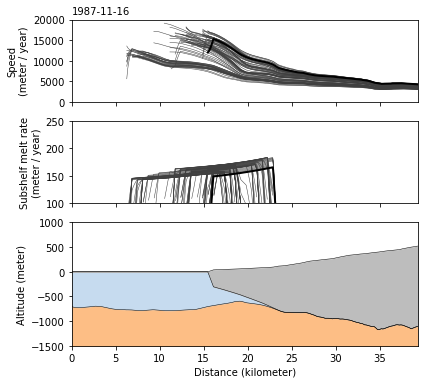

In [6]:
time = ds["time"].dt.strftime("%Y-%m-%d").values
profile_axis_units = ds.variables["profile_axis"].attrs["units"]
ds = ds.pint.quantify({"profile_axis": profile_axis_units, "vonmises_stress": None})
ds = ds.pint.to(profile_axis="km").pint.dequantify()


for profile_id in ds.variables["profile_id"]:
    profile_name = ds.variables["profile_name"][profile_id]
    profile_axis = ds.variables["profile_axis"][profile_id]
    x_min = profile_axis.min()
    x_max = profile_axis.max()

    surface = ds.variables["usurf"][profile_id,...]
    topography = ds.variables["topg"][profile_id,...]
    thickness = ds.variables["thk"][profile_id,...]
    speed = ds.variables["velsurf_mag"][profile_id, ...]
    speed = speed.where(speed > 10)
    basal_melt = ds.variables["bmelt"][profile_id, ...]
    basal_melt = basal_melt.where(basal_melt > 10)

    speed_rolling = xr.DataArray(speed).rolling(time=3).mean()
    basal_melt_rolling = xr.DataArray(basal_melt).rolling(time=3).mean()

    bottom = surface - thickness
    for t, date in enumerate(time):
        fig, axs = plt.subplots(3, 1, sharex="col", figsize=[6.2, 6], gridspec_kw=dict(height_ratios=[2, 2, 3]),
)
        axs[0].plot(profile_axis, speed_rolling[0:t, ...].T, color="0.75", lw=0.5)
        axs[0].plot(profile_axis, speed_rolling[t, ...], color="k", lw=2.0)
        axs[1].plot(profile_axis, basal_melt_rolling[0:t, ...].T, color="0.75", lw=0.5)
        axs[1].plot(profile_axis, basal_melt_rolling[t, ...], color="k", lw=2.0)

        axs[-1].fill_between(profile_axis, topography[t, ...] * 0 -2000, topography[t, ...] * 0, color="#c6dbef", linewidth=0.3)

        axs[-1].fill_between(profile_axis, bottom[t, ...], surface[t, ...], color="#bdbdbd", linewidth=0.5)
        axs[-1].fill_between(profile_axis, topography[t, ...] * 0 -2000, topography[t, ...], color="#fdbe85", linewidth=0.3)
        axs[-1].plot(profile_axis, topography[t, ...], color="k", lw=0.5)
        axs[-1].plot(profile_axis, bottom[t, ...], color="k", lw=0.5)
        axs[-1].plot(profile_axis, surface[t, ...], color="k", lw=0.5)
        axs[0].set_ylabel(f"""Speed\n({speed.attrs["units"]})""")
        axs[1].set_ylabel(f"""Subshelf melt rate\n({basal_melt.attrs["units"]})""")

        axs[-1].set_xlabel(f"""Distance ({profile_axis.attrs["units"]})""")
        axs[-1].set_ylabel(f"""Altitude ({surface.attrs["units"]})""")

        axs[0].text(0., 1.1, date, horizontalalignment='left',  verticalalignment='center', transform=axs[0].transAxes)
        axs[0].set_ylim(0, 20000)
        axs[1].set_ylim(100, 250)
        axs[-1].set_ylim(-1500, 1000)
        for ax in axs:
            ax.set_xlim(x_min, x_max)
        fig.savefig(f"flowline_{t:03d}.png", dpi=300)
        plt.close(plt.gcf())
        del fig
ds.close()

In [ ]:
ds.pint.quantify?

In [ ]:
847. / 4

In [ ]:
ls

In [ ]:
!rm *pdf

In [ ]:
from osgeo import gdal
from osgeo import ogr

In [ ]:
filename="/Users/andy/base/gris-analysis/flux-gates/jakobshavn-flowline-50m.gpkg"

In [ ]:
    from osgeo import ogr
    from osgeo import osr
    from osgeo import gdal

    ds = gdal.OpenEx(filename, 0)
    layer = ds.GetLayer(0)
    layer_type = ogr.GeometryTypeToName(layer.GetGeomType())
    srs = layer.GetSpatialRef()
    if not srs.IsGeographic():
        print(
            (
                """Spatial Reference System in % s is not latlon. Converting."""
                % filename
            )
        )
        # Create spatialReference (lonlat)
        srs_geo = osr.SpatialReference()
        srs_geo.ImportFromProj4("+proj=latlon")
    cnt = layer.GetFeatureCount()



In [ ]:
    profiles = []
    if layer_type == "Point":
        lon = []
        lat = []
        for pt in range(0, cnt):
            feature = layer.GetFeature(pt)

            try:
                id = feature.id
            except:
                id = str(pt)
            try:
                try:
                    name = feature.name
                except:
                    name = feature.Name
            except:
                name = str(pt)
            try:
                flightline = feature.flightline
            except:
                flightline = 2
            try:
                glaciertype = feature.gtype
            except:
                glaciertype = 4
            try:
                flowtype = feature.ftype
            except:
                flowtype = 2
            geometry = feature.GetGeometryRef()
            # Transform to latlon if needed
            if not srs.IsGeographic():
                geometry.TransformTo(srs_geo)

            point = geometry.GetPoint()
            lon.append(point[0])
            lat.append(point[1])

            try:
                clon = feature.clon
            except:
                clon = point[0]
            try:
                clat = feature.clat
            except:
                clat = point[1]

            profiles.append(
                [lat, lon, id, name, clat, clon, flightline, glaciertype, flowtype]
            )

    elif layer_type in ("Line String", "Multi Line String"):
        for pt in range(1, 2):
            feature = layer.GetFeature(pt)
            print(feature)
            try:
                id = feature.id
            except:
                id = str(pt)
            if id is None:
                id = str(pt)
            if feature.name is None:
                name = "unnamed"
            else:
                try:
                    name = feature.name
                except:
                    name = "unnamed"
            try:
                clon = feature.clon
            except:
                clon = 0.0
            try:
                clat = feature.clat
            except:
                clat = 0.0
            try:
                flightline = feature.flightline
            except:
                flightline = 2
            if flightline is None:
                flightline = 2
            try:
                glaciertype = feature.gtype
            except:
                glaciertype = 4
            if glaciertype is None:
                glaciertype = 4
            try:
                flowtype = feature.ftype
            except:
                flowtype = 2
            if flowtype is None:
                flowtype = 2
            geometry = feature.GetGeometryRef()
            # Transform to latlon if needed
            if not srs.IsGeographic():
                geometry.TransformTo(srs_geo)
            lon = []
            lat = []
            for i in range(0, geometry.GetPointCount()):
                # GetPoint returns a tuple not a Geometry
                pt = geometry.GetPoint(i)
                lon.append(pt[0])
                lat.append(pt[1])
            # skip features with less than 2 points:
            if len(lat) > 1:
                profiles.append(
                    [lat, lon, id, name, clat, clon, flightline, glaciertype, flowtype]
                )


In [ ]:
layer.GetFeatureCount()

In [ ]:
        for pt in range(0, cnt):
            feature = layer.GetFeature(pt)
            print(feature)



In [ ]:
layer_type = ogr.GeometryTypeToName(layer.GetGeomType())


In [ ]:
feature

In [ ]:
            feature = layer.GetFeature(pt)


In [ ]:
feature

In [ ]:
layer.GetFeature(1)

In [ ]:
for f in range(layer.GetFeatureCount()):
     print(layer.GetFeature(f))

In [ ]:
feature  = layer.GetFeature(1)

In [ ]:
feature.

In [ ]:
id

In [ ]:
name

In [ ]:
for f in layer:
    print(f.name)

In [ ]:
feature.items()

In [ ]:
loc=1e-11
scale=9.9e-10

In [ ]:
loc + scale